In [ ]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2


os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"  # Disable XLA devices

# Suppress Python warnings
warnings.filterwarnings('ignore')

# Disable XLA JIT compilation
tf.config.optimizer.set_jit(False)

# Disable eager execution of decorated tf.functions (optional)
tf.config.run_functions_eagerly(False)

print("TensorFlow version:", tf.__version__)

# Configure GPU (if available)
try:
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU devices: {gpus}")
except Exception as e:
    print(f"GPU configuration error: {e}")

2025-07-06 19:39:12.636606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751810952.728665     843 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751810952.755744     843 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751810952.963589     843 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751810952.963622     843 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751810952.963624     843 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# STEP 1: Clean corrupted images from dataset
def clean_dataset(dataset_path):
    """Remove corrupted images from the dataset."""
    corrupted_count = 0
    total_count = 0
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                file_path = os.path.join(root, file)
                total_count += 1
                
                try:
                    # Try to open and verify image
                    with Image.open(file_path) as img:
                        img.verify()
                    
                    # Try to load image data
                    with Image.open(file_path) as img:
                        img.load()
                        
                    # Additional check: ensure image has proper dimensions
                    if img.size[0] < 10 or img.size[1] < 10:
                        raise ValueError("Image too small")
                        
                except Exception as e:
                    print(f"Removing corrupted file: {file_path} - {str(e)}")
                    try:
                        os.remove(file_path)
                        corrupted_count += 1
                    except:
                        pass
    
    print(f"Dataset cleaning complete:")
    print(f"Total files processed: {total_count}")
    print(f"Corrupted files removed: {corrupted_count}")
    print(f"Clean files remaining: {total_count - corrupted_count}")


In [ ]:
DATASET_DIR = './dataset'
IMG_SIZE = (160, 160)  # Start with smaller size to avoid memory issues
BATCH_SIZE = 32
EPOCHS = 100

# Clean dataset first
print("Cleaning dataset...")
clean_dataset(DATASET_DIR)

Cleaning dataset...


In [4]:
# Simple data generators (no complex augmentation initially)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Load data with validation split
try:
    train_data = train_datagen.flow_from_directory(
        os.path.join(DATASET_DIR, 'train'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

    val_data = train_datagen.flow_from_directory(
        os.path.join(DATASET_DIR, 'val'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    test_data = test_datagen.flow_from_directory(
        os.path.join(DATASET_DIR, 'test'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    print(f"Training samples: {train_data.samples}")
    print(f"Validation samples: {val_data.samples}")
    print(f"Test samples: {test_data.samples}")
    print(f"Class indices: {train_data.class_indices}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check your dataset structure.")
    exit(1)

Found 140370 images belonging to 2 classes.
Found 17546 images belonging to 2 classes.
Found 17548 images belonging to 2 classes.
Training samples: 140370
Validation samples: 17546
Test samples: 17548
Class indices: {'fake': 0, 'real': 1}


In [6]:
# Improved CNN model
def create_model(input_shape):
    model = Sequential([
        # Block 1
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.25),
        
        # Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Dropout(0.25),
        
        # Block 4
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        
        # Dense layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create model
model = create_model((IMG_SIZE[0], IMG_SIZE[1], 3))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1751810963.731320     843 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 849,313 (3.24 MB)

 Trainable params: 847,329 (3.23 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [8]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model with error handling
print("Starting training...")
try:
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )
    
    print("Training completed successfully!")
    
except Exception as e:
    print(f"Training error: {e}")
    print("Trying with reduced parameters...")
    
    # Fallback training with reduced complexity
    BATCH_SIZE = 32
    
    # Recreate generators with smaller batch size
    train_data = train_datagen.flow_from_directory(
        os.path.join(DATASET_DIR, 'train'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )
    
    val_data = train_datagen.flow_from_directory(
        os.path.join(DATASET_DIR, 'train'),
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )
    
    # Retry training
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )


Starting training...
Epoch 1/100
 767/4387 ━━━━━━━━━━━━━━━━━━━━ 10:43 178ms/step - accuracy: 0.5463 - loss: 0.9147

2025-07-06 19:42:05.054053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3787', 8 bytes spill stores, 8 bytes spill loads

2025-07-06 19:42:05.614185: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4245', 28 bytes spill stores, 32 bytes spill loads

2025-07-06 19:42:05.859763: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4245', 32 bytes spill stores, 32 bytes spill loads

2025-07-06 19:42:05.900745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3787', 4 bytes spill stores, 4 bytes spill loads

2025-07-06 19:42:05.947550: I external/local

4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5998 - loss: 0.7924

2025-07-06 19:54:37.105579: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.58543, saving model to best_model.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 893s 203ms/step - accuracy: 0.5998 - loss: 0.7924 - val_accuracy: 0.5854 - val_loss: 1.1964 - learning_rate: 1.0000e-04
Epoch 2/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7690 - loss: 0.4881
Epoch 2: val_accuracy improved from 0.58543 to 0.68637, saving model to best_model.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 768s 175ms/step - accuracy: 0.7690 - loss: 0.4881 - val_accuracy: 0.6864 - val_loss: 0.7060 - learning_rate: 1.0000e-04
Epoch 3/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8247 - loss: 0.3882
Epoch 3: val_accuracy improved from 0.68637 to 0.75983, saving model to best_model.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 760s 173ms/step - accuracy: 0.8247 - loss: 0.3882 - val_accuracy: 0.7598 - val_loss: 0.5043 - learning_rate: 1.0000e-04
Epoch 4/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8536 - loss: 0.3316
Epoch 4: val_accuracy improved from 0.75983 to 0.76941, saving model to best_model.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 776s 177ms/step - accuracy: 0.8536 - loss: 0.3316 - val_accuracy: 0.7694 - val_loss: 0.4988 - learning_rate: 1.0000e-04
Epoch 5/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8771 - loss: 0.2880
Epoch 5: val_accuracy improved from 0.76941 to 0.78269, saving model to best_model.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 758s 173ms/step - accuracy: 0.8771 - loss: 0.2880 - val_accuracy: 0.7827 - val_loss: 0.5555 - learning_rate: 1.0000e-04
Epoch 6/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8945 - loss: 0.2540
Epoch 6: val_accuracy improved from 0.78269 to 0.88003, saving model to best_model.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 755s 172ms/step - accuracy: 0.8945 - loss: 0.2540 - val_accuracy: 0.8800 - val_loss: 0.3043 - learning_rate: 1.0000e-04
Epoch 7/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9067 - loss: 0.2275
Epoch 7: val_accuracy did not improve from 0.88003
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 728s 166ms/step - accuracy: 0.9067 - loss: 0.2275 - val_accuracy: 0.8095 - val_loss: 0.5104 - learning_rate: 1.0000e-04
Epoch 8/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9160 - loss: 0.2059
Epoch 8: val_accuracy did not improve from 0.88003
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 747s 170ms/step - accuracy: 0.9160 - loss: 0.2059 - val_accuracy: 0.7801 - val_loss: 0.6702 - learning_rate: 1.0000e-04
Epoch 9/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9260 - loss: 0.1843
Epoch 9: val_accuracy improved from 0.88003 to 0.92523, saving model to best_model.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 780s 178ms/step - accuracy: 0.9260 - loss: 0.1843 - val_accuracy: 0.9252 - val_loss: 0.1889 - learning_rate: 1.0000e-04
Epoch 10/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9307 - loss: 0.1733
Epoch 10: val_accuracy did not improve from 0.92523
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 755s 172ms/step - accuracy: 0.9307 - loss: 0.1733 - val_accuracy: 0.9051 - val_loss: 0.2283 - learning_rate: 1.0000e-04
Epoch 11/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9386 - loss: 0.1550
Epoch 11: val_accuracy did not improve from 0.92523
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 742s 169ms/step - accuracy: 0.9386 - loss: 0.1550 - val_accuracy: 0.8630 - val_loss: 0.3972 - learning_rate: 1.0000e-04
Epoch 12/100
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9430 - loss: 0.1452
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 12: val_accuracy did not improve from 0.92523
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 805s 1

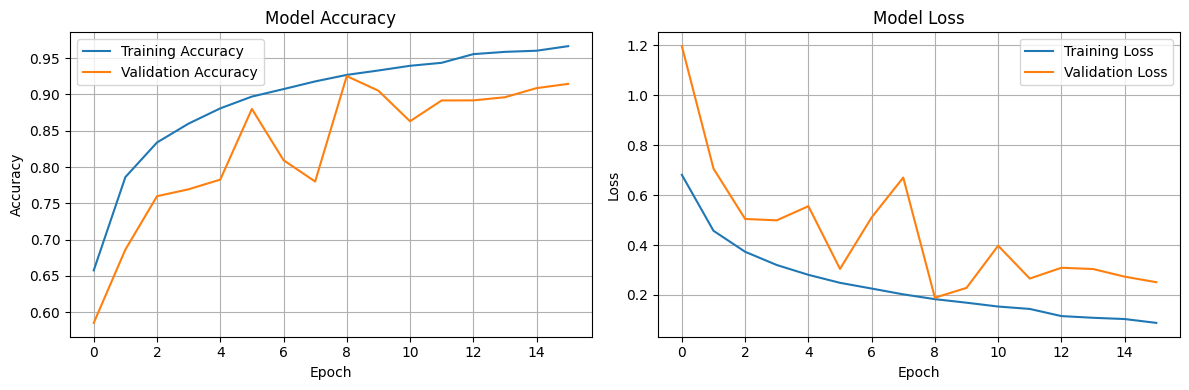

In [9]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [10]:
# Evaluate model
print("Evaluating model...")
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")


Evaluating model...
547/549 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9052 - loss: 0.2363

2025-07-06 23:10:12.303865: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 8 bytes spill stores, 8 bytes spill loads



549/549 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9053 - loss: 0.2361
Test Accuracy: 0.9165


549/549 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step

Classification Report:
              precision    recall  f1-score   support

        Real       0.92      0.90      0.91      8124
        Fake       0.91      0.93      0.92      9424

    accuracy                           0.92     17548
   macro avg       0.92      0.92      0.92     17548
weighted avg       0.92      0.92      0.92     17548



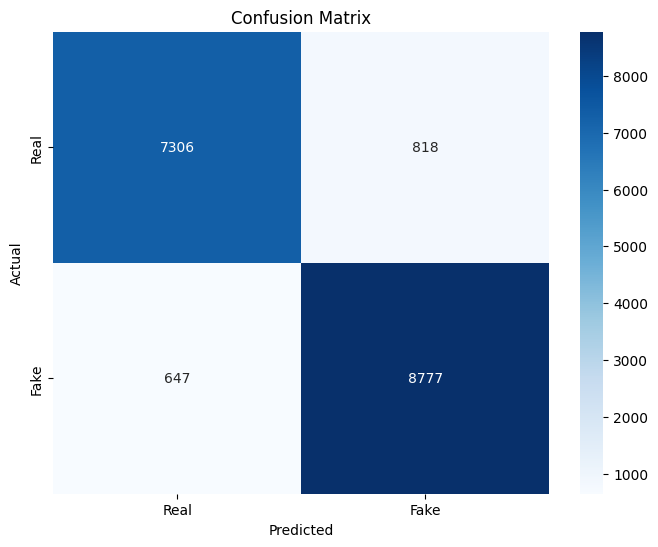

In [11]:
# Generate predictions
test_predictions = model.predict(test_data)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Get true labels
test_labels = test_data.classes

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions_binary.flatten(), target_names=['Real', 'Fake']))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions_binary.flatten())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
model.save("facecheck_final.keras")

In [15]:
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 0.9165
